# Скаченные библиотики

In [3]:
!conda install -y -c rdkit rdkit;
!pip install git+https://github.com/samoturk/mol2vec;

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.7.12
  latest version: 4.8.0rc0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - rdkit


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    rdkit-2018.09.1.0          |   py36h71b666b_1        20.2 MB  rdkit
    ------------------------------------------------------------
                                           Total:        20.2 MB

The following NEW packages will be INSTALLED:

  rdkit              rdkit/linux-64::rdkit-2018.09.1.0-py36h71b666b_1



rdkit-2018.09.1.0    | 20.2 MB   | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
  Cloning https://github.com/samoturk/mol2vec to /tmp/pip-req

In [4]:
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import numpy as np
from rdkit import Chem
import pandas as pd
from rdkit.Chem import AllChem
import numpy as np
from sklearn.utils import shuffle
from rdkit.Chem import rdChemReactions
from rdkit import Chem 
from sklearn import preprocessing
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from rdkit.Chem import Descriptors
from gensim.models import word2vec
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec
from gensim.models import word2vec
from rdkit.Chem import Descriptors
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/rdkit/Chem/PandasTools.py", line 131, in <module>
    if 'display.width' in pd.core.config._registered_options:
AttributeError: module 'pandas.core' has no attribute 'config'
/opt/conda/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [5]:
# Функция для визулизации
def evaluation(model, X_test, y_test):
    prediction = model.predict(X_test)
    mae = mean_absolute_error(y_test, prediction)
    mse = mean_squared_error(y_test, prediction)
    
    plt.figure(figsize=(15, 10))
    plt.plot(prediction[:300], "red", label="prediction", linewidth=1.0)
    plt.plot(y_test[:300], 'green', label="actual", linewidth=1.0)
    plt.legend()
    plt.ylabel('logP')
    plt.title("MAE {}, MSE {}".format(round(mae, 4), round(mse, 4)))
    plt.show()
    
    print('MAE score:', round(mae, 4))
    print('MSE score:', round(mse,4))


# Информация о данных

In [6]:
data = pd.read_csv("../input/biocad-data/data_clean.csv")

In [7]:
data.head()

,molecule,QPlogS
0,COc1ccc(CCNC(=O)c2cc3c(-c4ccccc4F)nn(C)c3s2)cc1OC,-6.668
1,COCc1noc(-c2cccc(NC(=O)[C@H]3CCO[C@@H]3C(C)C)c...,-4.380
2,C[C@H](NC(=O)N[C@H]1CC[C@H](CO)CC1)c1nc2ccccc2...,-5.235
3,CC(C)CCOCCNC(=O)C(=O)NCc1cc(COC(C)(C)C)on1,-4.761
4,C/C(O)=N/C[C@H]1CN(Cc2csc(N(C)C3CC3)n2)CCO1,-4.219


In [8]:
data.shape

(994682, 2)

In [9]:
data.describe()

,QPlogS
count,994682.000000
mean,-3.599817
std,1.505771
min,-24.094000
25%,-4.599000
50%,-3.645000
75%,-2.635000
max,2.000000


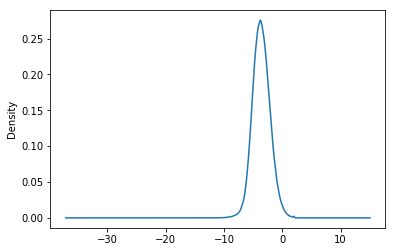

In [10]:
s = pd.Series(data.QPlogS.values)
s.plot.kde()

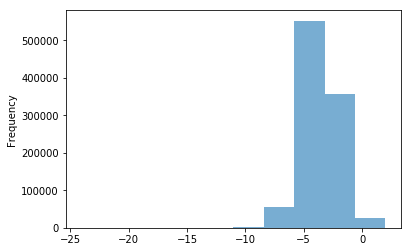

In [11]:
s.plot.hist(alpha=0.6)

# Уменьшим размер данных

In [12]:
data = shuffle(data)
data.index = range(994682)
data = data.loc[0:100000 - 1]

In [13]:
data.describe()

,QPlogS
count,100000.000000
mean,-3.605233
std,1.501913
min,-15.402000
25%,-4.602000
50%,-3.655000
75%,-2.647000
max,2.000000


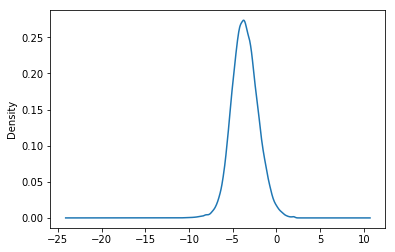

In [14]:
s = pd.Series(data.QPlogS.values)
s.plot.kde()

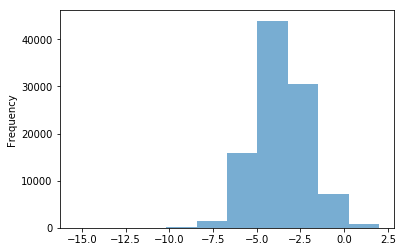

In [15]:
s.plot.hist(alpha=0.6)

# Привидем SMILES запись малекулы к каноничному виду

In [16]:
data['mol'] = data['molecule'].apply(lambda x: Chem.MolFromSmiles(x))

# Добавим численные признаки взятые из основных свойств молекул
Информация была взята:
* https://www.rdkit.org/docs/source/rdkit.Chem.rdchem.html
* https://www.rdkit.org/docs/source/rdkit.Chem.Descriptors.html
* https://www.rdkit.org/docs/RDKit_Book.html

In [17]:
data['num_of_atoms'] = data['mol'].apply(lambda x: x.GetNumAtoms())
data['num_of_heavy_atoms'] = data['mol'].apply(lambda x: x.GetNumHeavyAtoms())
data['num_of_bonds'] = data['mol'].apply(lambda x: x.GetNumBonds())
data['tpsa'] = data['mol'].apply(lambda x: Descriptors.TPSA(x))
data['mol_w'] = data['mol'].apply(lambda x: Descriptors.ExactMolWt(x))
data['num_valence_electrons'] = data['mol'].apply(lambda x: Descriptors.NumValenceElectrons(x))
data['num_heteroatoms'] =data['mol'].apply(lambda x: Descriptors.NumHeteroatoms(x))

# Подсчитаем наиболее распространенные атомы и запищем их как признак
* https://sourceforge.net/p/rdkit/mailman/message/34524687

In [18]:
data['num_of_C_atoms'] = data['mol'].apply(lambda x: len(x.GetSubstructMatches(Chem.MolFromSmiles('C'))))
data['num_of_O_atoms'] = data['mol'].apply(lambda x: len(x.GetSubstructMatches(Chem.MolFromSmiles('O'))))
data['num_of_Cl_atoms'] = data['mol'].apply(lambda x: len(x.GetSubstructMatches(Chem.MolFromSmiles('Cl'))))
data['num_of_N_atoms'] = data['mol'].apply(lambda x: len(x.GetSubstructMatches(Chem.MolFromSmiles('N'))))
data['num_of_P_atoms'] = data['mol'].apply(lambda x: len(x.GetSubstructMatches(Chem.MolFromSmiles('P'))))

In [19]:
data.drop(columns = 'mol').head(20)

,molecule,QPlogS,num_of_atoms,num_of_heavy_atoms,num_of_bonds,tpsa,mol_w,num_valence_electrons,num_heteroatoms,num_of_C_atoms,num_of_O_atoms,num_of_Cl_atoms,num_of_N_atoms,num_of_P_atoms
0,Cc1nc(CCNC(=O)C(=O)Nc2ccc3c(C)nn(C)c3c2)n[nH]1,-5.0830,25,25,27,117.59,341.160023,130,9,16,2,0,7,0
1,C[C@@H]1CCc2[nH]c3ccc(C(=O)Nc4cccc([C@@H]5CNC(...,-5.4750,29,29,33,73.99,387.194677,148,5,24,2,0,3,0
2,COc1c2[nH]ccc2ccc1Br,-2.7090,12,12,13,25.02,224.978926,62,3,9,1,0,1,0
3,CCc1occc1C(=O)N1CCN(S(=O)(=O)c2ccc(C(C)=O)cc2)CC1,-2.0470,27,27,29,87.90,390.124943,144,8,19,5,0,2,0
4,C=CCCC/C=C/CN(C/C=C\CCCC=C)CCCCC,-3.1270,22,22,21,3.24,303.292600,126,1,21,0,0,1,0
5,O=C(NC[C@@H]1CCCOC1)N1CCC[C@@H]1c1nnc2n1CCCCC2,-4.8880,25,25,28,72.28,347.232125,138,7,18,2,0,5,0
6,CNC(=O)NCC(=O)N1C[C@@H](C)C[C@H]1c1cccnc1,-2.7130,20,20,21,74.33,276.158626,108,6,14,2,0,4,0
7,CC[C@@H](C)[C@H](O)C(=O)NC1CCN(C2CCN(C)CC2)CC1,-1.1730,22,22,23,55.81,311.257277,128,5,17,2,0,3,0
8,COC(=O)c1sccc1NC(=O)C(=O)NC[C@H](OC)C(C)C,-4.0220,22,22,22,93.73,328.109293,122,8,14,5,0,2,0
9,COC(=O)CC[C@@H](NC(=O)CCc1cccc(OC2CCCC2)c1)C(=...,-5.9580,28,28,29,90.93,391.199488,154,7,21,6,0,1,0


In [20]:
data.loc[data['num_of_atoms'] != data['num_of_heavy_atoms']]

,molecule,QPlogS,mol,num_of_atoms,num_of_heavy_atoms,num_of_bonds,tpsa,mol_w,num_valence_electrons,num_heteroatoms,num_of_C_atoms,num_of_O_atoms,num_of_Cl_atoms,num_of_N_atoms,num_of_P_atoms


In [21]:
data['num_of_P_atoms'].describe()

count    100000.000000
mean          0.000240
std           0.017319
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           3.000000
Name: num_of_P_atoms, dtype: float64

### уберем признак num_of_heavy_atoms, потому что он совпадает num_of_atoms

In [22]:
data = data.drop(columns = 'num_of_heavy_atoms')

# Разобьём данные на тренировочную и тестовую выборку

In [23]:
train_df = data.drop(columns=['molecule', 'mol', 'QPlogS'])
y = data['QPlogS'].values

In [24]:
train_df.head()

,num_of_atoms,num_of_bonds,tpsa,mol_w,num_valence_electrons,num_heteroatoms,num_of_C_atoms,num_of_O_atoms,num_of_Cl_atoms,num_of_N_atoms,num_of_P_atoms
0,25,27,117.59,341.160023,130,9,16,2,0,7,0
1,29,33,73.99,387.194677,148,5,24,2,0,3,0
2,12,13,25.02,224.978926,62,3,9,1,0,1,0
3,27,29,87.90,390.124943,144,8,19,5,0,2,0
4,22,21,3.24,303.292600,126,1,21,0,0,1,0


In [25]:
X_train, X_test, y_train, y_test = train_test_split(train_df, y, test_size=.2, random_state=17)

# Гребневая регрессия

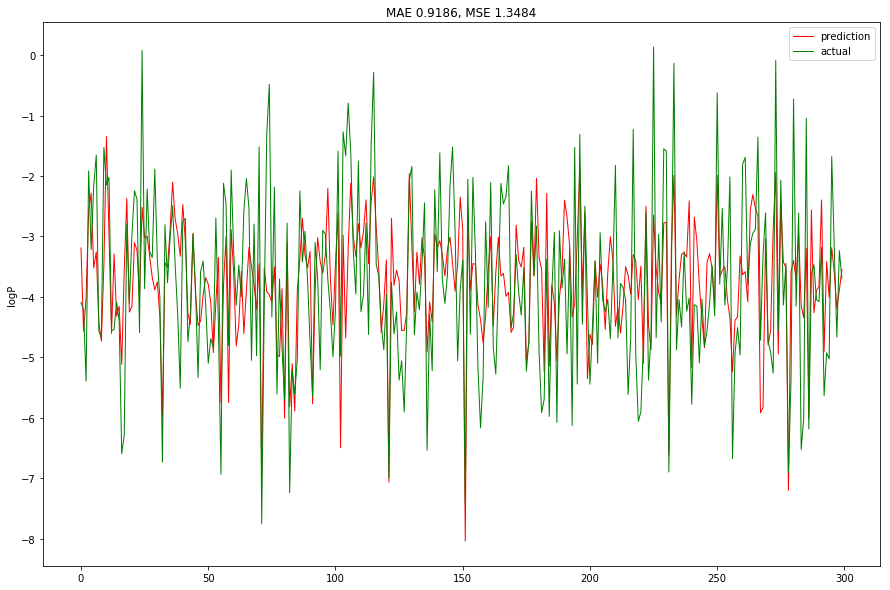

MAE score: 0.9186
MSE score: 1.3484


In [26]:
ridge = RidgeCV(cv=5)
ridge.fit(X_train, y_train)
evaluation(ridge, X_test, y_test)

In [27]:
joblib.dump(ridge, "ridge.pkl")

['ridge.pkl']

# Cлучайный лес

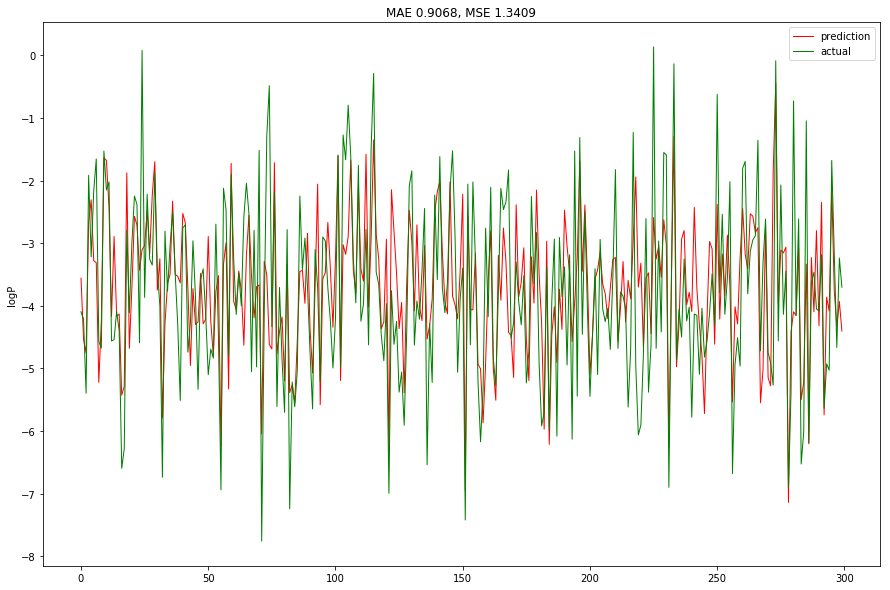

MAE score: 0.9068
MSE score: 1.3409


In [28]:
forest = RandomForestRegressor(n_estimators=1000, random_state=17)
forest.fit(X_train, y_train)
evaluation(forest, X_test, y_test)

In [29]:
joblib.dump(ridge, "ridge.pkl")

['ridge.pkl']

# K ближайших соседей

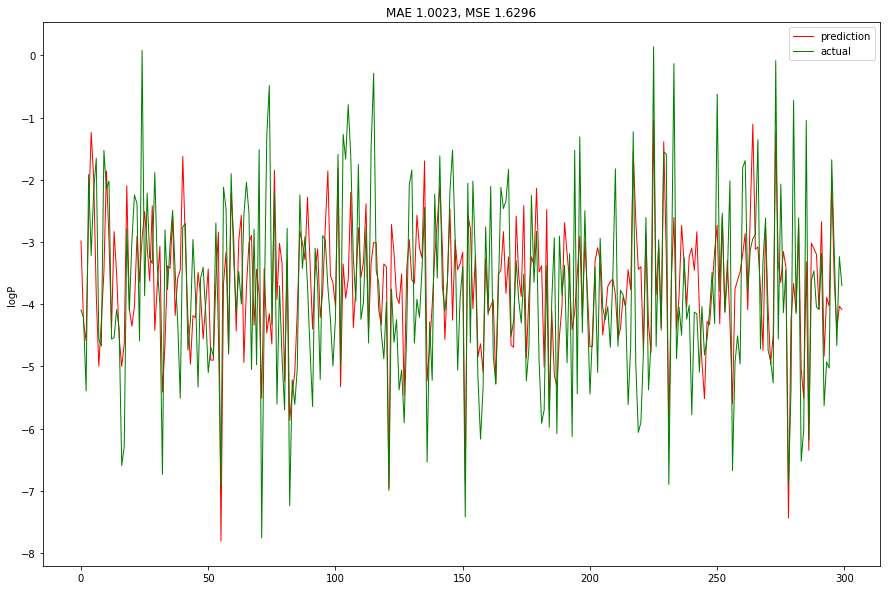

MAE score: 1.0023
MSE score: 1.6296


In [30]:
neigh = KNeighborsRegressor(n_neighbors=5)
neigh.fit(X_train, y_train)
evaluation(neigh, X_test, y_test)

# Градиентный бустинг

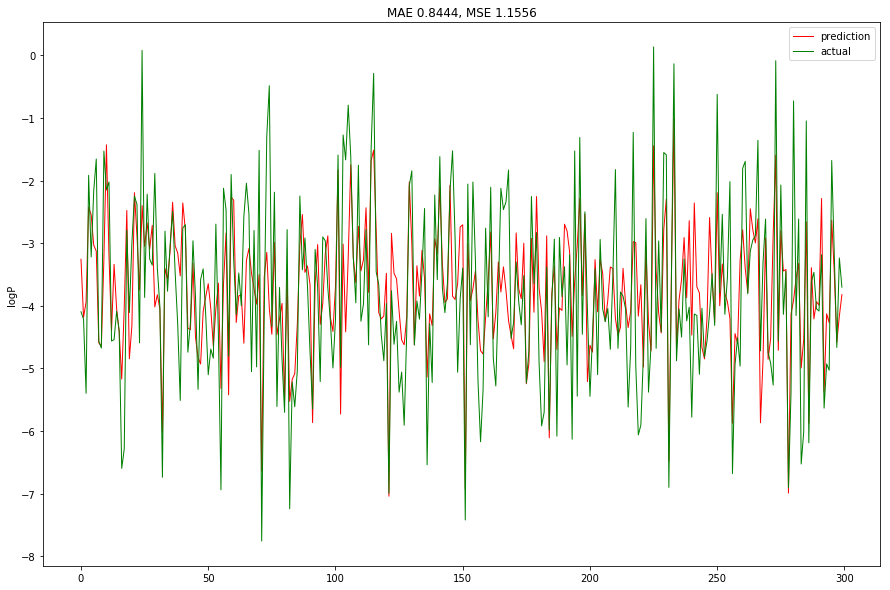

MAE score: 0.8444
MSE score: 1.1556


In [31]:
gbrt=GradientBoostingRegressor(n_estimators=1500)
gbrt.fit(X_train, y_train)
evaluation(gbrt, X_test, y_test)

In [32]:
joblib.dump(gbrt, "gbrt.pkl")

['gbrt.pkl']

# mol2vec
* ссылка: https://s3-eu-west-1.amazonaws.com/itempdf74155353254prod/5513581/Mol2vec__Unsupervised_Machine_Learning_Approach_with_Chemical_Intuition_v1.pdf
* предобученная помель была взята: https://github.com/samoturk/mol2vec

In [38]:
mdf = data
mdf = mdf.drop(columns=['mol', 'num_of_atoms', 'num_of_bonds', 'tpsa', 'mol_w', 'num_valence_electrons', 'num_heteroatoms', 
                     'num_of_C_atoms', 'num_of_O_atoms', 'num_of_Cl_atoms', 'num_of_N_atoms', 'num_of_P_atoms'])

In [39]:
target = mdf['QPlogS']
mdf.drop(columns='QPlogS',inplace=True)

In [40]:
mdf['mol'] = mdf['molecule'].apply(lambda x: Chem.MolFromSmiles(x))

In [41]:
model = word2vec.Word2Vec.load('/kaggle/input/model-300dim/model_300dim.pkl')

mdf['sentence'] = mdf.apply(lambda x: MolSentence(mol2alt_sentence(x['mol'], 1)), axis=1)

mdf['mol2vec'] = [DfVec(x) for x in sentences2vec(mdf['sentence'], model, unseen='UNK')]
X = np.array([x.vec for x in mdf['mol2vec']])
y = target.values

In [42]:
X.shape

(100000, 300)

# Гребневая регрессия

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=17)

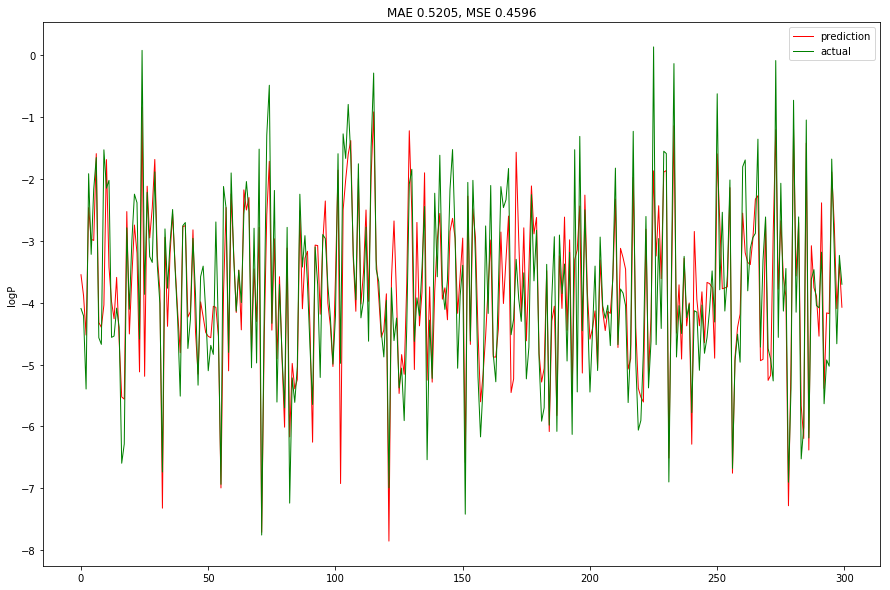

MAE score: 0.5205
MSE score: 0.4596


In [44]:
ridge_mol2vec = RidgeCV(cv=5)
ridge_mol2vec.fit(X_train, y_train)
evaluation(ridge_mol2vec, X_test, y_test)

In [45]:
joblib.dump(ridge_mol2vec, "ridge_mol2vec.pkl")

['ridge_mol2vec.pkl']

# Случайный лес

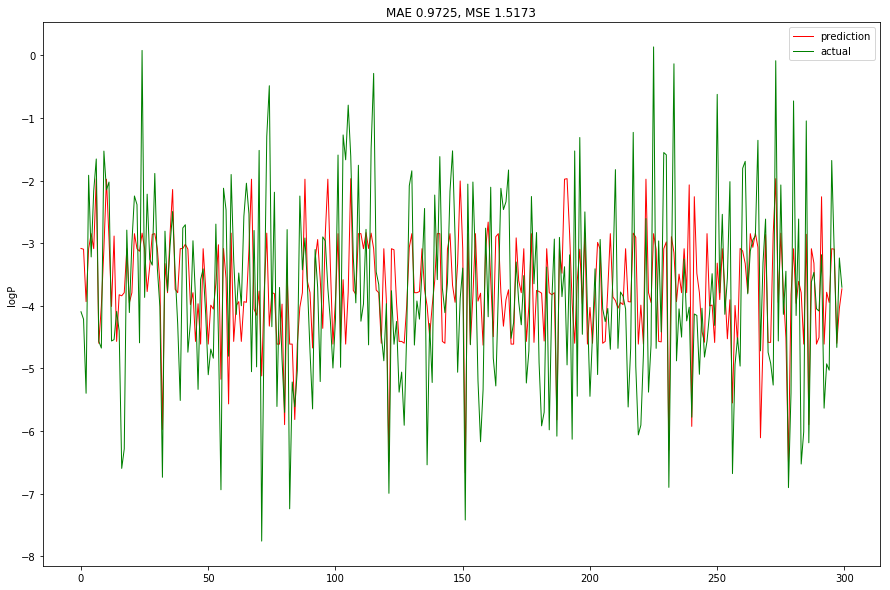

MAE score: 0.9725
MSE score: 1.5173


In [46]:
forest_mol2vec = RandomForestRegressor(n_estimators=100, random_state=17, max_depth = 3)
forest_mol2vec.fit(X_train, y_train)
evaluation(forest_mol2vec, X_test, y_test)

# Градиентный бустинг

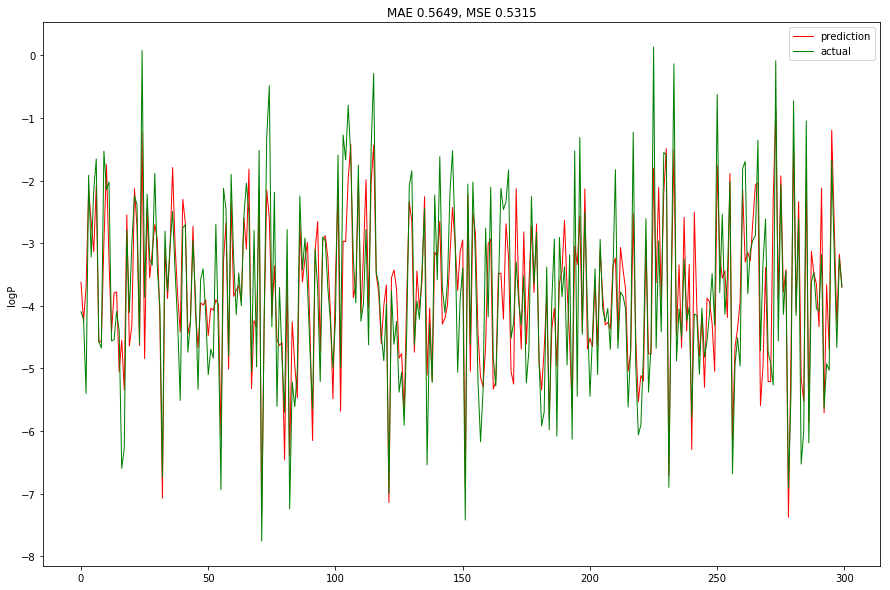

MAE score: 0.5649
MSE score: 0.5315


In [48]:
gbrt_mol2vec=GradientBoostingRegressor(n_estimators = 1000)
gbrt_mol2vec.fit(X_train, y_train)
evaluation(gbrt_mol2vec, X_test, y_test)

In [49]:
joblib.dump(gbrt_mol2vec, "gbrt_mol2vec.pkl")

['gbrt_mol2vec.pkl']

# Совместим признаки

In [53]:
mdf = pd.DataFrame(X)
new_df = pd.concat((mdf, train_df), axis=1)

In [54]:
X_train, X_test, y_train, y_test = train_test_split(new_df, y, test_size=.1, random_state=1)

# Гребневая регрессия

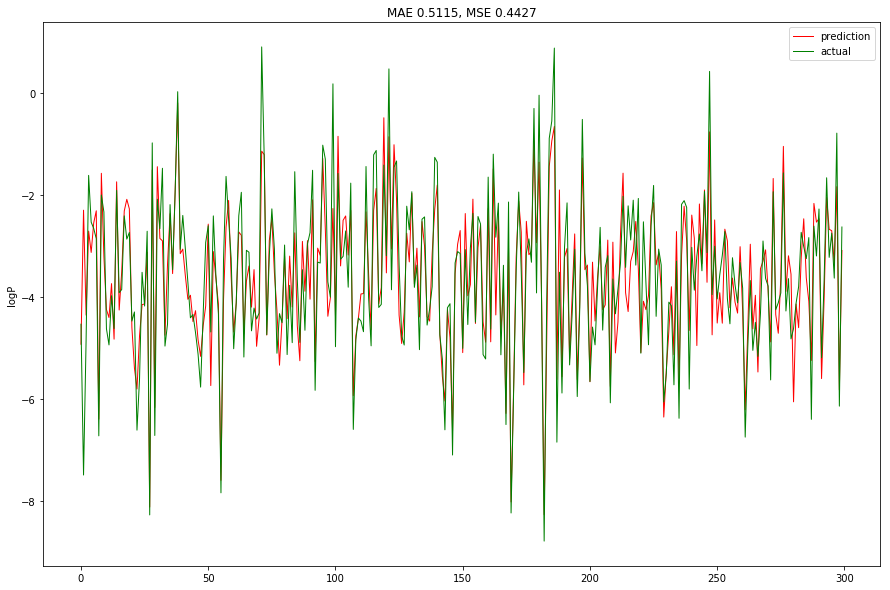

MAE score: 0.5115
MSE score: 0.4427


In [57]:
ridge_concat = RidgeCV(cv=5)
ridge_concat.fit(X_train, y_train)
evaluation(ridge_concat, X_test, y_test)

In [58]:
joblib.dump(ridge_concat, "ridge_concat.pkl")

['ridge_concat.pkl']